<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/develop/JoohyunKwon/logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/6000_IMDB_Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [7]:
reviews=list(df['review'])
sentiments=list(df['sentiment'])

In [8]:
from sklearn.model_selection import train_test_split
X =np.array(reviews)
y=np.array(sentiments)

X_train, X_eval, y_train, y_eval=train_test_split(X, y, test_size=0.2)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec=TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_features=5000)
tfidf_vec.fit(X_train)
X_train_tfidf_vec = tfidf_vec.transform(X_train)
X_eval_tfidf_vec = tfidf_vec.transform(X_eval)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lgs=LogisticRegression(class_weight='balanced')
lgs.fit(X_train_tfidf_vec, y_train)
pred=lgs.predict(X_eval_tfidf_vec)
print('TF-IDF Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_eval, pred)))


TF-IDF Logistic Regression 의 예측 정확도는 0.841


In [11]:
from sklearn.model_selection import GridSearchCV
params = {'C':[0.01, 0.1, 1, 5, 10]}#C:regularization
grid_cv_lr = GridSearchCV(lgs, param_grid=params, cv = 3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vec, y_train)
print('Logistic Regression best C parmeter:', grid_cv_lr.best_params_)

#최적 C 값으로 학습된 grid_cv로 예측 및 정확도 평가
pred = grid_cv_lr.predict(X_eval_tfidf_vec)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_eval, pred)))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression best C parmeter: {'C': 5}
TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.848


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_eval, pred))

              precision    recall  f1-score   support

    negative       0.85      0.84      0.84       594
    positive       0.84      0.86      0.85       606

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



Text(0.5, -0.15, 'F1 Score: 0.8501 Precision: 0.8439 Recall: 0.8564')

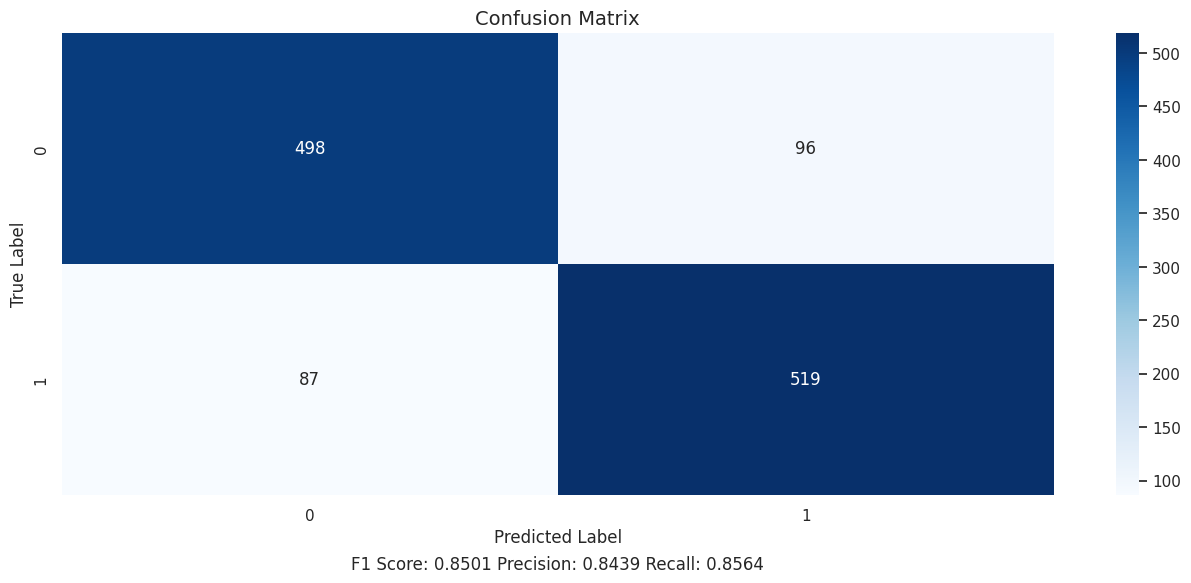

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
cm1 =confusion_matrix(y_eval,pred) #confusin matrix
f1_1 =f1_score(y_eval,pred,pos_label='positive') #f1score
precision_1 =precision_score(y_eval,pred,pos_label='positive')#precision
recall_1 =recall_score(y_eval,pred,pos_label='positive')#recall
fig, axes = plt.subplots(figsize=(16, 6))

# 첫 번째 subplot: baseline model
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='d', ax=axes) #cm1 시각화
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1_1:.4f} Precision: {precision_1:.4f} Recall: {recall_1:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
             fontsize=12)

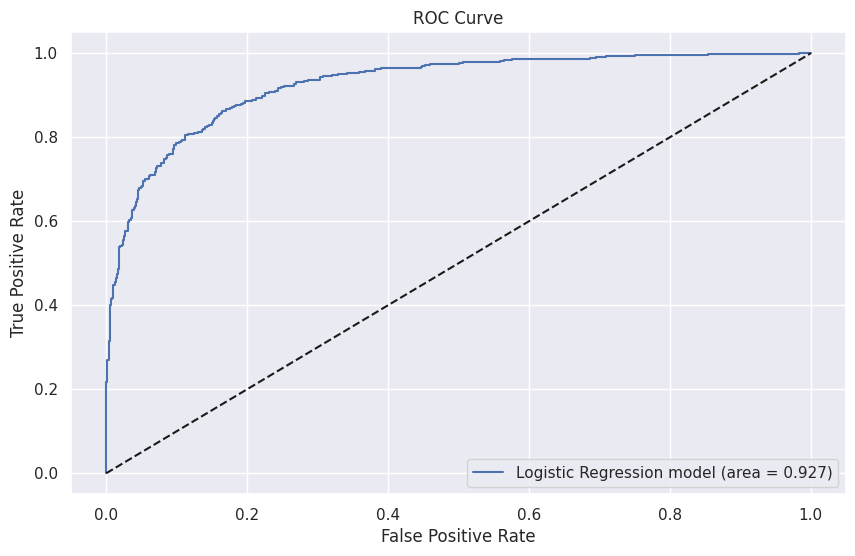

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_proba = grid_cv_lr.predict_proba(X_eval_tfidf_vec)[:, 1]#baseline의 예측확률을 계산
fp_lr, tp_lr,_ = roc_curve(y_eval, lr_proba,pos_label='positive')#roc curve를 계산
auroc_baseline = roc_auc_score(y_eval, lr_proba)#auroc를 계산

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fp_lr, tp_lr, label=f'Logistic Regression model (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()